In [2]:
import networkx as nx
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch

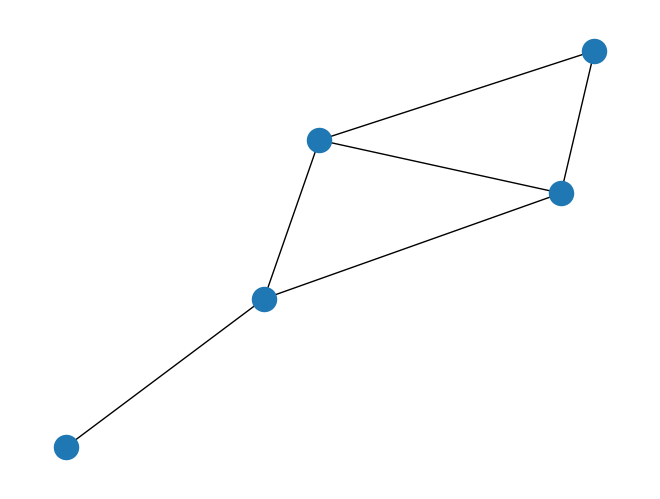

In [59]:
graph = nx.Graph()

# Adding node, edges and node feature into Graph
graph.add_nodes_from([1,2,3,4,5])
graph.add_edges_from([(1,2), (1,3), (3,5), (4,5), (5,2), (2,3)])
graph.nodes[1]['feature'] = [5,5]
graph.nodes[2]['feature'] = [15,5]
graph.nodes[3]['feature'] = [10,12]
graph.nodes[4]['feature'] = [1,1]
graph.nodes[5]['feature'] = [5,17]

graph.nodes[1]['y'] = [183.0]
graph.nodes[2]['y'] = [214.5]
graph.nodes[3]['y'] = [269.0]
graph.nodes[4]['y'] = [123.0]
graph.nodes[5]['y'] = [198.5]  ### Noise

nx.draw(graph)

# Little Big Graph than prevous

In [14]:
# (5**2 + 5) + (pow((1**2 + 3**2),0.5) + pow((15**2 + 20**2),0.5))

58.16227766016838

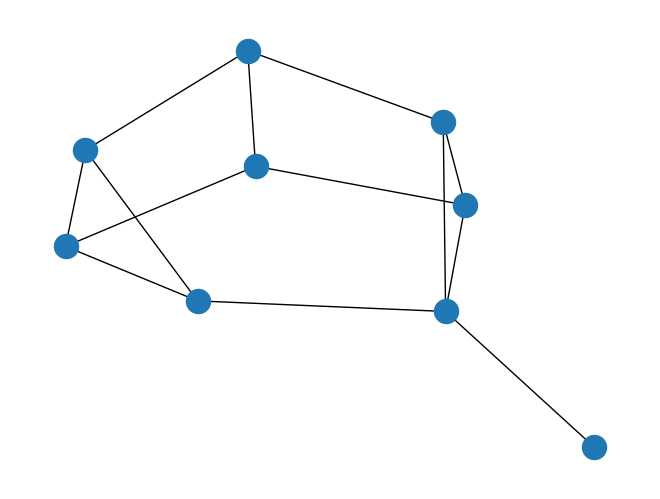

In [15]:
# graph = nx.Graph()

# # Adding node, edges and node feature into Graph
# graph.add_nodes_from([0,1,2,3,4,5,6,7,8])
# graph.add_edges_from([(0,1), (0,6), (0,7), (1,2), (1,5), (2,3), (2,4), (3,4), (3,7), (4,5), (5,6), (6,7), (7,8)])
# graph.nodes[0]['feature'] = [1,3]
# graph.nodes[1]['feature'] = [5,5]
# graph.nodes[2]['feature'] = [15,20]
# graph.nodes[3]['feature'] = [12,13]
# graph.nodes[4]['feature'] = [17,20]
# graph.nodes[5]['feature'] = [20,12]   #Noise
# graph.nodes[6]['feature'] = [2,4]
# graph.nodes[7]['feature'] = [5,4]
# graph.nodes[8]['feature'] = [6,5]

# # Relation: y = (x_1^2 + x_2) + (sample two neiborhood(a,b) ||a||.||b||)
# graph.nodes[0]['y'] = [18.21]
# graph.nodes[1]['y'] = [58.16]
# graph.nodes[2]['y'] = [278.31]
# graph.nodes[3]['y'] = [188.40]
# graph.nodes[4]['y'] = [351.69]
# graph.nodes[5]['y'] = [442.72]
# graph.nodes[6]['y'] = [23.62]  # Extra added node_7, node_8
# graph.nodes[7]['y'] = [54.32]  # 3 Neiborhood
# graph.nodes[8]['y'] = [47.40]  ### Noise

# nx.draw(graph)

# Pre-trainning

In [60]:
# Converting graph to adjacensy matrix
adj_mat = nx.to_numpy_array(graph)
num_nodes = graph.number_of_nodes()

#### Can be calculated Degree Matrix here or later
# degree_mat = np.zeros((num_nodes,num_nodes))
# for i, node in zip(range(num_nodes),graph.nodes()):
#   degree_mat[i, i] = graph.degree()[node]
## OR Self-Loop
degree_mat = np.sum(adj_mat + np.eye(adj_mat.shape[0]), axis=1)

# Calculating feature matrix
feature_vec_len = len(graph.nodes[1]['feature'])
feature_mat = np.zeros((num_nodes, feature_vec_len))
y = np.zeros((num_nodes, 1))
for i in range(num_nodes):
  feature_mat[i] = graph.nodes[i+1]['feature']
  y[i] = graph.nodes[i+1]['y']

In [61]:
# Find global min and max
global_min = np.min(feature_mat)
global_max = np.max(feature_mat)

# Apply min-max normalization
minmax_norm_feat_mat = (feature_mat - global_min) / (global_max - global_min)

# Converting to tensor
minmax_norm_feat_mat = torch.FloatTensor(minmax_norm_feat_mat)
y = torch.FloatTensor(y)

## All GOOD till here

In [100]:
#### Adding masks

### For large graph
# train_mask_index = [0,4,6,7,3]
# test_mask_index = [1,2,5,8]

### For small dataset
train_mask_index = [1,2,4,3]
test_mask_index = [0]

# for Y
y_train_mask = torch.zeros_like(torch.tensor(y))
y_test_mask = torch.zeros_like(torch.tensor(y))

y_train_mask[train_mask_index] = 1.0
y_test_mask[test_mask_index] = 1.0

# For feat mat
train_mask = torch.zeros_like(torch.tensor(minmax_norm_feat_mat))
test_mask = torch.zeros_like(torch.tensor(minmax_norm_feat_mat))

train_mask[train_mask_index] = 1.0
test_mask[test_mask_index] = 1.0

# train_mask = train_mask * torch.tensor(minmax_norm_feat_mat)
# test_mask = test_mask * torch.tensor(minmax_norm_feat_mat)

/tmp/ipython-input-1812984864.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_mask = torch.zeros_like(torch.tensor(y))
/tmp/ipython-input-1812984864.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_mask = torch.zeros_like(torch.tensor(y))
/tmp/ipython-input-1812984864.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_mask = torch.zeros_like(torch.tensor(minmax_norm_feat_mat))
/tmp/ipython-input-1812984864.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().cl

In [101]:
class GCN(nn.Module):
  def __init__(self, in_feature, out_feature, hidden, adj_mat) -> None:
    super(GCN, self).__init__()
    self.linear1 = nn.Linear(in_feature, hidden)
    self.linear2 = nn.Linear(hidden, out_feature)

    ## calclating A during initialization
    degree_mat = np.sum(adj_mat, axis=1)

    # Converting into the form D^(1/2)AD^(1/2)
    norm_degree_mat = np.diag(np.power(degree_mat, -0.5))
    spectral_mat = norm_degree_mat.dot(adj_mat).dot(norm_degree_mat)

    # Convert matrices to tensors
    self.adj_matrix_tensor = torch.FloatTensor(spectral_mat)

  def forward(self, feature_mat, mask):
    # feature_matrix_tensor = torch.FloatTensor(feature_mat)

    # print(feature_mat)
    inp = torch.matmul(self.adj_matrix_tensor, feature_mat)
    # print(self.linear.weight, inp)
    x = F.relu(self.linear1(inp * mask))
    x = self.linear2(x)
    output = F.relu(x)

    return output

In [102]:
# Creating GCN layer
model = GCN(in_feature=2, out_feature=1, hidden=2, adj_mat=adj_mat)
outputs = model(minmax_norm_feat_mat, train_mask)

# Embeddings
outputs

tensor([[0.6824],
        [0.4822],
        [0.5176],
        [0.4702],
        [0.5811]], grad_fn=<ReluBackward0>)

In [109]:
leaning_rate = 0.01
decay = 5e-4

optimizer = torch.optim.Adam(model.parameters(),
                             lr=leaning_rate,
                             weight_decay=decay
                             )
criterion = nn.MSELoss()


def train():
  model.train()
  optimizer.zero_grad()
  out = model(minmax_norm_feat_mat, train_mask)

  loss = criterion(out, y * y_train_mask)
  loss.backward()
  optimizer.step()

  return loss

def test():
  model.eval()
  out = model(minmax_norm_feat_mat, test_mask)

  test_acc  = criterion(out, y * y_test_mask)

  return test_acc

losses = []
for epoc in range(10001):
  loss = train()
  losses.append(loss)
  if epoc % 1000 == 0:
    print(f"Epoc: {epoc:03d}, Loss: {loss:.4f}")

Epoc: 000, Loss: 175.9556
Epoc: 1000, Loss: 175.9556
Epoc: 2000, Loss: 175.9558
Epoc: 3000, Loss: 175.9554
Epoc: 4000, Loss: 175.9555
Epoc: 5000, Loss: 175.9555
Epoc: 6000, Loss: 175.9556
Epoc: 7000, Loss: 175.9554
Epoc: 8000, Loss: 175.9555
Epoc: 9000, Loss: 175.9555
Epoc: 10000, Loss: 175.9553


In [110]:
y * y_train_mask

tensor([[  0.0000],
        [214.5000],
        [269.0000],
        [123.0000],
        [198.5000]])

In [111]:
model(minmax_norm_feat_mat, train_mask)

tensor([[  0.0000],
        [231.0901],
        [247.2590],
        [117.8737],
        [208.7758]], grad_fn=<ReluBackward0>)

In [112]:
y * y_test_mask

tensor([[183.],
        [  0.],
        [  0.],
        [  0.],
        [  0.]])

In [113]:
model(minmax_norm_feat_mat, test_mask)

tensor([[267.6838],
        [  0.0000],
        [  0.0000],
        [  0.0000],
        [  0.0000]], grad_fn=<ReluBackward0>)

In [66]:
torch.zeros_like(torch.tensor(minmax_norm_feat_mat))

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], dtype=torch.float64)

In [63]:
# Original tensor matrix
matrix = torch.tensor([[1., 2., 3.],
                       [4., 5., 6.],
                       [7., 8., 9.]])

# Define the index of the row to mask (e.g., the second row, index 1)
row_index_to_mask = [1, 2]

# Create a mask tensor.
# 1s for rows to keep, 0s for rows to mask.
mask = torch.ones_like(matrix)
mask[row_index_to_mask] = 0.

# Apply the mask by element-wise multiplication
masked_matrix = matrix * mask

print("Original Matrix:")
print(matrix)
print("\nMask Tensor:")
print(mask)
print("\nMasked Matrix (row 1 is zeroed out):")
print(masked_matrix)

Original Matrix:
tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

Mask Tensor:
tensor([[1., 1., 1.],
        [0., 0., 0.],
        [0., 0., 0.]])

Masked Matrix (row 1 is zeroed out):
tensor([[1., 2., 3.],
        [0., 0., 0.],
        [0., 0., 0.]])
